In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
DRIVE_BASE_PATH = "/content/gdrive/My\ Drive/Colab\ Notebooks/"

In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [0]:
!pip install -q fastai==0.7.0 torchtext==0.2.3

In [0]:
from fastai.conv_learner import *
from fastai.dataset import *
from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

In [0]:
!wget -qq http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
!tar -xf VOCtrainval_06-Nov-2007.tar
!wget -qq https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip
!unzip -q PASCAL_VOC.zip
!mkdir -p data/pascal
!mv PASCAL_VOC/* data/pascal
!mv VOCdevkit data/pascal

In [0]:
PATH = Path('data/pascal')
trn_j = json.load((PATH/'pascal_train2007.json').open())
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']

FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

cats = {o[ID]:o['name'] for o in trn_j[CATEGORIES]}
trn_fns = {o[ID]:o[FILE_NAME] for o in trn_j[IMAGES]}
trn_ids = [o[ID] for o in trn_j[IMAGES]]

JPEGS = 'VOCdevkit/VOC2007/JPEGImages'
IMG_PATH = PATH/JPEGS

In [0]:
def hw_bb(bb): return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

trn_anno = collections.defaultdict(lambda:[])
for o in trn_j[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = hw_bb(bb)
        trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))

In [0]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [0]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

In [0]:
def draw_outline(o, lw, foreground_color='black'):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground=foreground_color), patheffects.Normal()])
    
def draw_rect(ax, b, color="white", foreground_color='black'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4, foreground_color)

def draw_text(ax, xy, txt, sz=14,color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)    

In [0]:
def get_lrg(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]

In [0]:
trn_lrg_anno = {a: get_lrg(b) for a,b in trn_anno.items()}

In [0]:
(PATH/'tmp').mkdir(exist_ok=True)
CSV = PATH/'tmp/lrg.csv'

In [0]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids],
    'cat': [cats[trn_lrg_anno[o][1]] for o in trn_ids]}, columns=['fn','cat'])
df.to_csv(CSV, index=False)

In [0]:
BB_CSV = PATH/'tmp/bb.csv'

In [0]:
bb = np.array([trn_lrg_anno[o][0] for o in trn_ids])
bbs = [' '.join(str(p) for p in o) for o in bb]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': bbs}, columns=['fn','bbox'])
df.to_csv(BB_CSV, index=False)

In [0]:
f_model=resnet34
sz=224
bs=64

val_idxs = get_cv_idxs(len(trn_fns))

In [0]:
tfm_y = TfmType.COORD
augs = [RandomFlip(tfm_y=tfm_y),
        RandomRotate(3, p=0.5, tfm_y=tfm_y),  #maximum of 3 degrees of rotation
        RandomLighting(0.05,0.05, tfm_y=tfm_y)]

In [0]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)

In [0]:
# localizer data
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms,
   bs=bs, continuous=True, val_idxs=val_idxs)

# largest object classifier data
md2 = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms_from_model(f_model, sz))

In [0]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2): self.ds,self.y2 = ds,y2
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [0]:
trn_ds2 = ConcatLblDataset(md.trn_ds, md2.trn_y)
val_ds2 = ConcatLblDataset(md.val_ds, md2.val_y)

In [24]:
trn_ds2[0][1]

(array([ 62.,  68., 180., 156.], dtype=float32), 6)

In [0]:
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [0]:
def show_training_batch(batch_num):
    trn_iter = iter(md.trn_dl)
    for i in range(batch_num):
        next(trn_iter)
    x,y = next(trn_iter)

    fig, axes = plt.subplots(3, 4, figsize=(10, 6))
    fig.suptitle('One training batch', fontsize=16)
    for i,ax in enumerate(axes.flat):
        ima=md.trn_ds.ds.denorm(to_np(x))[i]
        b = bb_hw(to_np(y[0][i]))
        ax = show_img(ima, ax=ax)
        draw_rect(ax, b)
        draw_text(ax, b[:2], md2.classes[y[1][i]])
    fig_name = f'training-batch-{batch_num}.png'
#     plt.savefig(fig_name)
#     print(f'![{fig_name}](/images/understanding-object-detection-part-2/{fig_name})')
#     plt.close(fig)
#     plt.tight_layout()

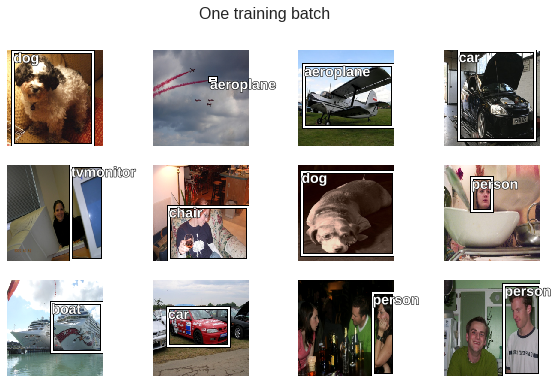

In [28]:
show_training_batch(2)

In [29]:
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512*7*7,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+len(cats)),
)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)

learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:04<00:00, 21136363.38it/s]


In [0]:
learn.model[8]

Sequential(
  (0): Flatten(
  )
  (1): ReLU()
  (2): Dropout(p=0.5)
  (3): Linear(in_features=25088, out_features=256, bias=True)
  (4): ReLU()
  (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True)
  (6): Dropout(p=0.5)
  (7): Linear(in_features=256, out_features=24, bias=True)
)

In [0]:
def detn_loss(input, target):
    bb_targ,c_targ = target
    bb_inp,c_inp = input[:, :4], input[:, 4:]
    
    bb_inp = F.sigmoid(bb_inp)*224

    return F.l1_loss(bb_inp, bb_targ) + F.cross_entropy(c_inp, c_targ)*20

In [0]:
def detn_l1(input, target):
    bb_targ,_ = target
    bb_inp = input[:, :4]
    bb_inp = F.sigmoid(bb_inp)*224
    return F.l1_loss(V(bb_inp),V(bb_targ)).data

def detn_acc(input, target):
    _,c_targ = target
    c_inp = input[:, 4:]
    return accuracy(c_inp, c_targ)

In [0]:
learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]

 97%|█████████▋| 31/32 [00:36<00:00,  2.54it/s, loss=601]

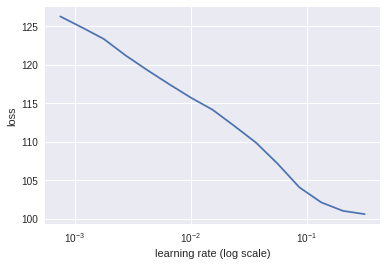

In [0]:
learn.lr_find()
learn.sched.plot()

In [0]:
lr=1e-2

In [0]:
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5))

epoch      trn_loss   val_loss   detn_acc   detn_l1    
    0      72.976483  44.597288  0.79       31.657924 
    1      53.448595  36.711062  0.826      25.718313 
    2      44.457675  35.144379  0.84       24.485125 


[array([35.14438]), 0.8399999976158142, 24.485124588012695]

In [0]:
learn.save('single-obj-both-1')

In [0]:
MODEL_NAME = 'single-obj-both-1.h5'

In [0]:
!mkdir -p {DRIVE_BASE_PATH}saved_models/fai_part_2/lec_9

In [0]:
!cp {PATH}/models/{MODEL_NAME} {DRIVE_BASE_PATH}saved_models/fai_part_2/lec_9/

In [0]:
!cp {DRIVE_BASE_PATH}saved_models/fai_part_2/lec_9/{MODEL_NAME} {PATH}/models/

In [0]:
learn.load('single-obj-both-1')

In [0]:
learn.freeze_to(-2)

In [0]:
lrs = np.array([lr/100, lr/10, lr])

A Jupyter Widget

 91%|█████████ | 29/32 [00:09<00:01,  2.99it/s, loss=308] 


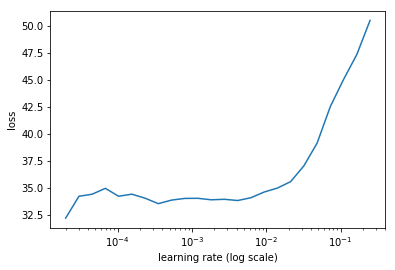

In [0]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [0]:
learn.fit(lrs/5, 1, cycle_len=5, use_clr=(32,10))

epoch      trn_loss   val_loss   detn_acc   detn_l1    
    0      37.499393  35.342807  0.79       22.659201 
    1      32.100903  32.894774  0.828      21.364469 
    2      27.395781  31.612098  0.83       20.496989 
    3      24.118376  30.928467  0.84       19.8688   
    4      21.751545  30.357756  0.836      19.526993 


[array([30.35776]), 0.8360000023841858, 19.52699264526367]

In [0]:
learn.save('reg1_1')

In [0]:
learn.load('reg1_1')

In [0]:
learn.unfreeze()

In [0]:
learn.fit(lrs/10, 1, cycle_len=10, use_clr=(32,10))

epoch      trn_loss   val_loss   detn_acc   detn_l1    
    0      19.095751  31.384051  0.814      19.595566 
    1      18.454536  30.605338  0.822      19.458042 
    2      17.760305  30.329738  0.828      19.527608 
    3      16.92527   29.743063  0.828      18.627137 
    4      16.159306  30.282852  0.832      18.666305 
    5      15.2422    30.32975   0.822      18.639726 


In [0]:
learn.save('single-obj-both-2')

In [0]:
MODEL_NAME = 'single-obj-both-2.h5'

In [0]:
!cp {PATH}/models/{MODEL_NAME} {DRIVE_BASE_PATH}saved_models/fai_part_2/lec_9/

In [0]:
!cp {DRIVE_BASE_PATH}saved_models/fai_part_2/lec_9/{MODEL_NAME} {PATH}/models/

In [0]:
learn.load('single-obj-both-2')

In [0]:
from scipy.special import expit

In [0]:
def show_validation_batch(batch_num, num_rows=3,num_cols=4, subset_num=0):
    val_iter = iter(md.val_dl)
    for i in range(batch_num):
        next(val_iter)

    x,ground_truth = next(val_iter)

    subset_len = num_rows*num_cols
#     pdb.set_trace()
    
    x = x[subset_len*subset_num:]
    ground_truth[0] = ground_truth[0][subset_len*subset_num:]
    ground_truth[1] = ground_truth[1][subset_len*subset_num:]
    
    learn.model.eval()
    preds = to_np(learn.model(VV(x)))
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 9))
    fig.suptitle('Results on validation batch', fontsize=16)
    for i,ax in enumerate(axes.flat):
        ima=md.val_ds.ds.denorm(to_np(x))[i]
        bb = expit(preds[i][:4])*224
        
        predicted_bb = bb_hw(bb)
        predicted_class = np.argmax(preds[i][4:])
        
        actual_bb = bb_hw(to_np(ground_truth[0][i]))
        actual_class = ground_truth[1][i]
        
        ax = show_img(ima, ax=ax)
        
#         draw prediction
        draw_rect(ax, predicted_bb)
        draw_text(ax, predicted_bb[:2], md2.classes[predicted_class])
#         draw ground truth
        draw_rect(ax, actual_bb, color="red")
        if not predicted_class == actual_class:
            draw_text(ax, actual_bb[:2], md2.classes[actual_class], color="red")
    fig_name = f'validation-batch-{batch_num}.png'
#     plt.savefig(fig_name)
#     print(f'![{fig_name}](/images/understanding-object-detection-part-2/{fig_name})')
#     plt.close(fig)
#     plt.tight_layout()

The white bounding boxes and text correspond to predictions, and the red ones correspond to the ground truth. Multiple labels are shown only when the model mis-classifies the largest object.

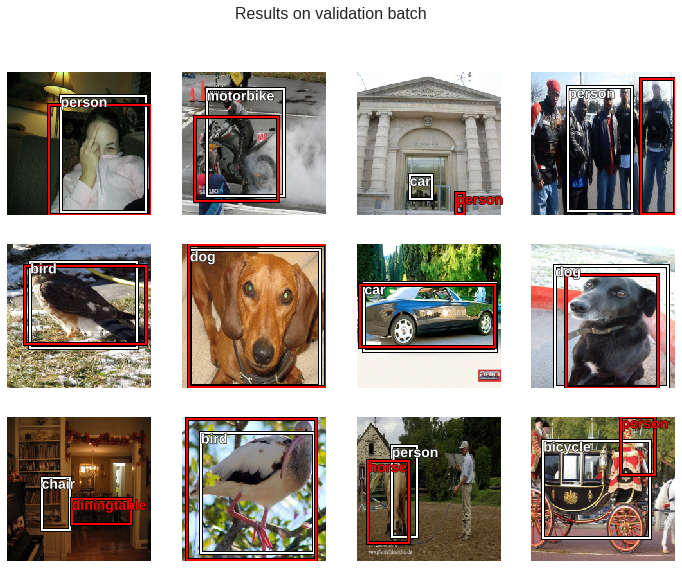

In [48]:
show_validation_batch(1)

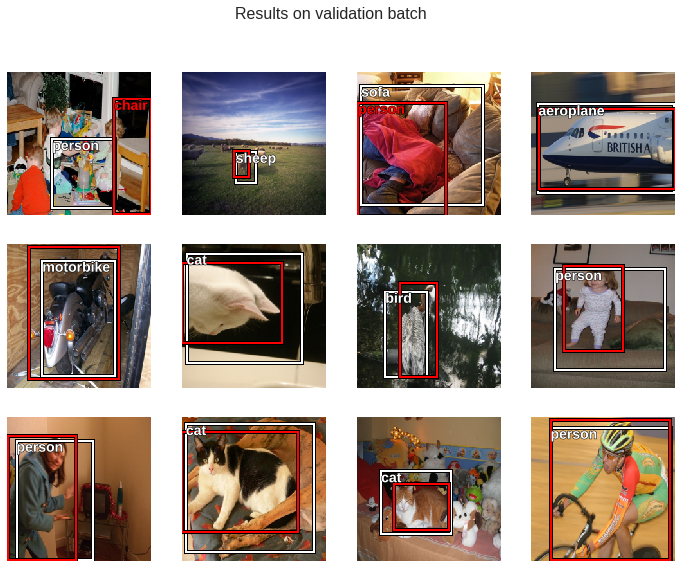

In [47]:
show_validation_batch(1, subset_num=1)

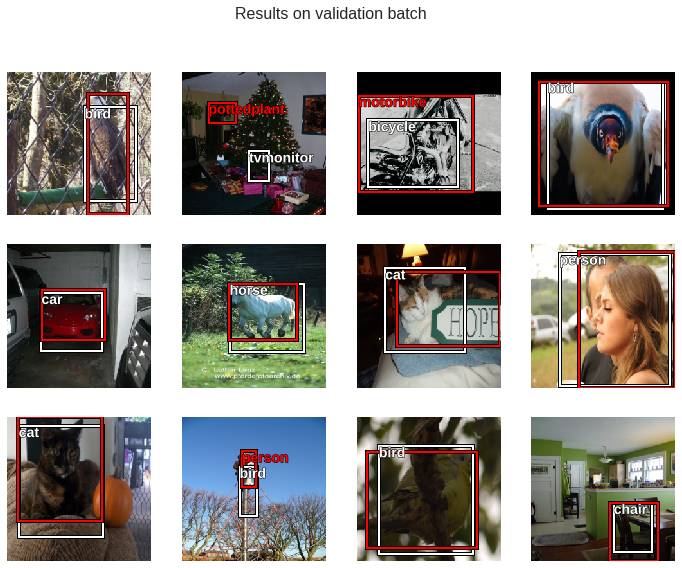

In [49]:
show_validation_batch(1, subset_num=2)

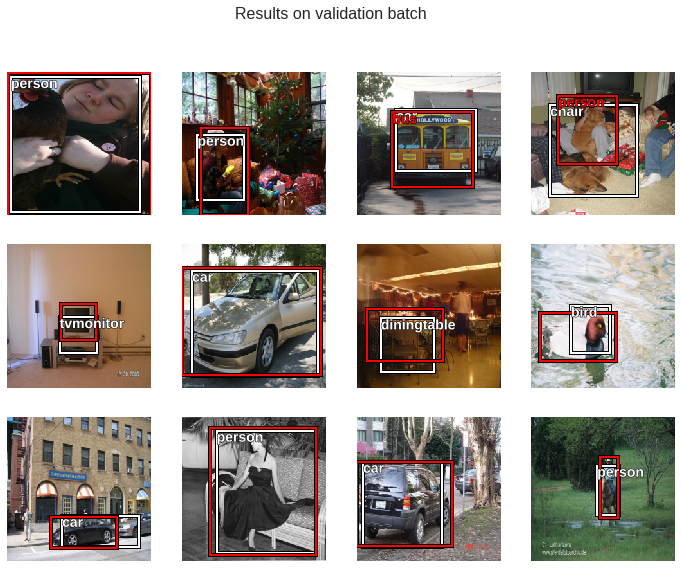

In [51]:
show_validation_batch(1, subset_num=3)

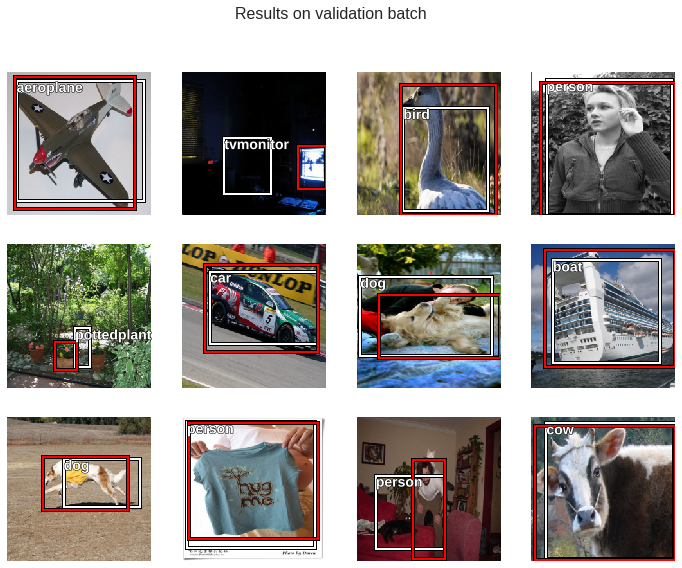

In [52]:
show_validation_batch(1, subset_num=4)

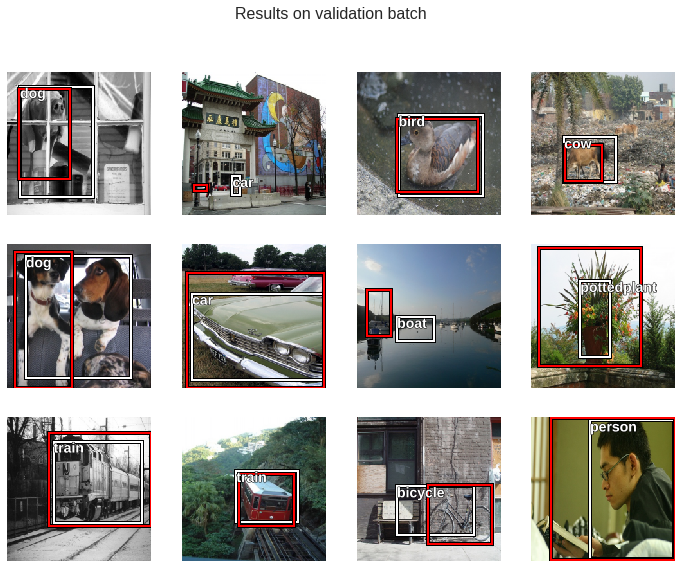

In [56]:
show_validation_batch(2, subset_num=0)

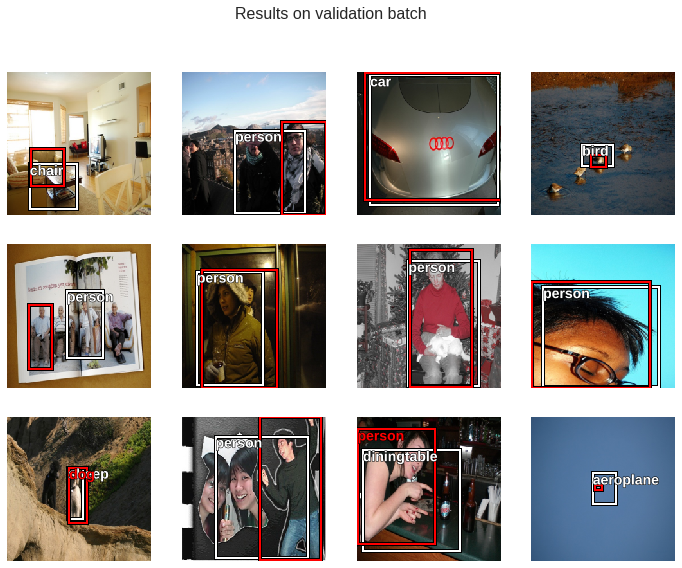

In [57]:
show_validation_batch(2, subset_num=1)

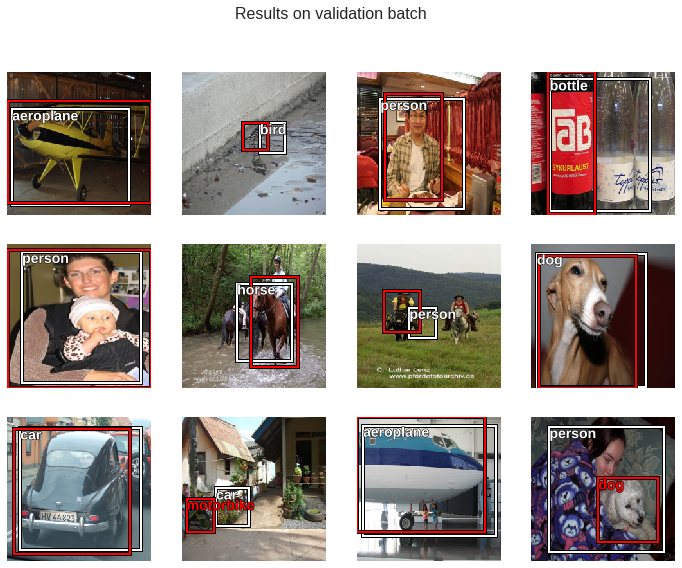

In [59]:
show_validation_batch(2, subset_num=2)

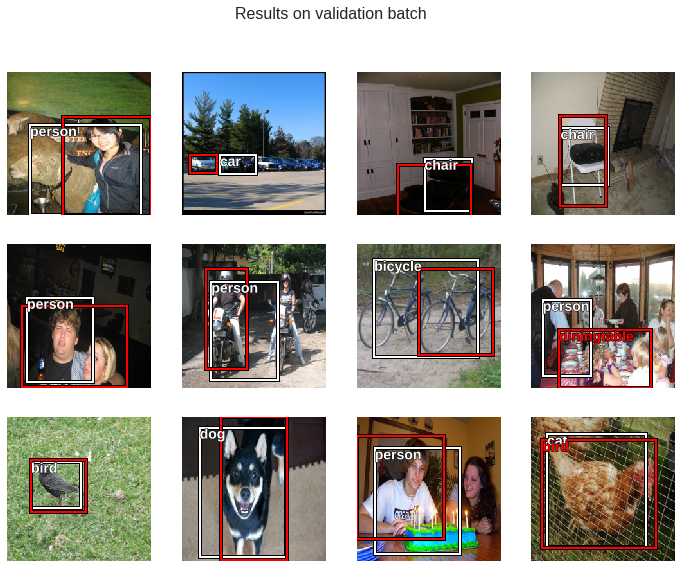

In [60]:
show_validation_batch(2, subset_num=3)

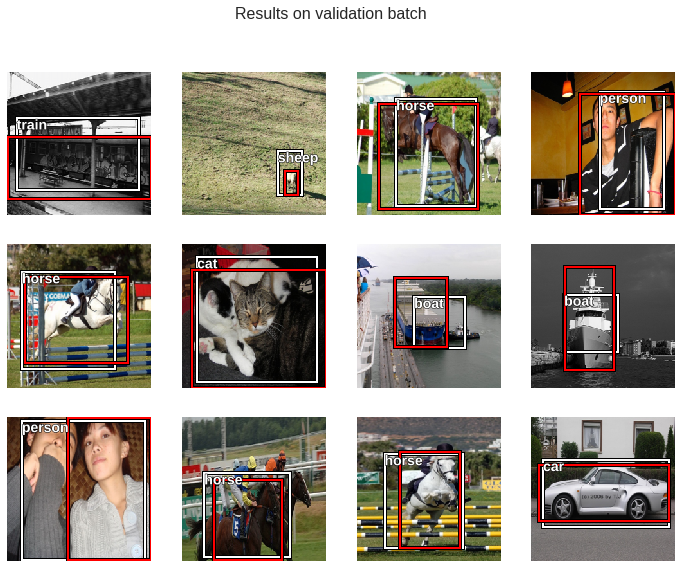

In [61]:
show_validation_batch(2, subset_num=4)

### References:
- https://course.fast.ai/part2.html